# Gaussian Hidden Markov Models

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
from posteriors import wishart,norm, dirichlet, simul_s, _Phi,order
from simulation import simul_gauss
from HMM import HMM

# We will fit a two component poisson HMM

A 2 components gaussian HMM is made of :
* A posterior `normal-inverse_wishart` distribution over $\theta = (\mu,\Sigma) \in IR^{2xd}xIR^{2xdxd}$; where $d$ = dim of the gaussian vectors
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by defining the posterior of $\theta = \left(\mu,\Sigma\right)$

In [5]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \0mega^{-1} is simulated instead \Omega

#Let set the default parameters

d = 3 # dim of our gaussian vectors

nu = np.array([20, 20]) # Degree of freedoms of the prior of \Omega
omega_inv = 30*np.array([np.eye(d), np.eye(d)]) # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d), np.zeros(d)]) # Mean of the prior over  \mu
sigma = 30*np.array([np.eye(d), np.eye(d) ]) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)
tDictDist["mu"]._set( mu = mu, sigma_inv = sigma)
tDictDist["omega_inv"]._set(nu = nu, omega_inv = omega_inv)

Now, the **S** distribtuion ...

In [6]:
sDist = simul_s(func = _Phi) # S distribution

Now the $P$ distribution

In [7]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[0.5, 0.5], [0.5,0.5]]))

In [8]:
pDist.default

{'a': 1}

# The gaussian mixture on an artificial data

Let's simulate an artificial gaussian mixture

In [56]:
P0 = np.array([[0.2, 0.8], [0.6, 0.4]]) # the 'true' transition matrix
mu0 = np.array([-5*np.ones(d), 5*np.ones(d)])# The 'true' means
sigma0 = 25*np.array([np.eye(d), np.eye(d)]) # The true cov matrixes

In [57]:
y, S0 = simul_gauss(P0,mu0, sigma0, 500) # Simulate 500 sample of poisson mixtures
y[:5] , S0[:5] 

(array([[ -7.96440281,  -7.40442549,  -1.95913377],
        [  8.99711852,  12.10382075,  10.31862283],
        [  1.90794341,  -8.38621995, -13.13837456],
        [ -3.50073875, -16.05524381,   2.69899936],
        [  1.0767939 ,   9.88418432,  -6.92474439]]), array([0, 1, 0, 0, 1]))

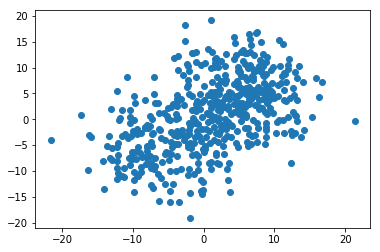

In [58]:
plt.scatter(y[:,0], y[:, 1])  # Our clusters

Now, we're gonna define the gHMM

In [59]:
Y = y # Obs
S = np.random.choice(2, len(Y)) # Initial states
P = np.array([[0.5,0.5],[0.5,0.5]]) # Initial transition matrix
mu =  np.array([ np.zeros(d), np.zeros(d) ]) # Inital 'mean'
omega_inv =  np.array([np.eye(d),np.eye(d)])/30 # Initial cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Inital parameters sample

In [60]:
ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [63]:
ghmm.run(50) # Start the gibbs sampler n-times

# Can we recover the true clusters ? Let's see !

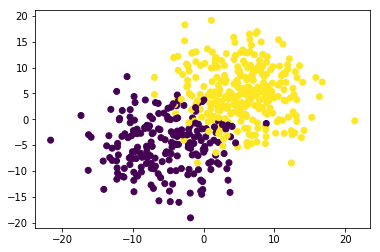

In [64]:
plt.scatter(Y[:,0], Y[:,1], c= ghmm.S)

In [65]:
(ghmm.sDist.rvs() == S0).mean() # Precision or Error rate

0.952

In [71]:
# Compute the mode for each obs
Sgmm = np.array(ghmm.H["S"][-20::])
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = 2 )
Sgmm = Sgmm.argmax(0)
Sgmm[:10]

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0])

In [72]:
(Sgmm == S0 ).mean() # Precision or Error rate

0.974

In [73]:
ghmm.Theta

{'mu': array([[-5.74993153, -5.19857438, -5.14737085],
        [ 5.53633568,  5.16330957,  4.61696398]]),
 'omega_inv': array([[[ 0.04390328,  0.00247158,  0.00085026],
         [ 0.00247158,  0.04791372, -0.00803168],
         [ 0.00085026, -0.00803168,  0.04997656]],
 
        [[ 0.05090171, -0.00013867,  0.00836531],
         [-0.00013867,  0.0401342 ,  0.00306966],
         [ 0.00836531,  0.00306966,  0.04423674]]])}

In [74]:
ghmm.tListDictDist["mu"].rvs()

array([[-5.83248208, -5.52502222, -4.94037892],
       [ 5.05773826,  5.72982216,  4.91161754]])

In [75]:
np.linalg.inv(ghmm.tListDictDist["omega_inv"].rvs()).round(2)

array([[[24.18, -0.07, -0.57],
        [-0.07, 21.22,  0.81],
        [-0.57,  0.81, 22.6 ]],

       [[22.15, -1.85, -0.85],
        [-1.85, 28.32, -1.32],
        [-0.85, -1.32, 20.72]]])

In [76]:
[history["mu"] for history in ghmm.H["Theta"][-5::]] # Last 5 mu samples

[array([[-5.2307302 , -5.57640353, -4.50918331],
        [ 5.39491471,  4.98548202,  5.15007579]]),
 array([[-5.92375586, -4.60285706, -4.7509775 ],
        [ 5.37806064,  4.89795569,  4.7540835 ]]),
 array([[-5.61358807, -5.24024712, -4.91575371],
        [ 5.58562357,  4.8138895 ,  4.91017991]]),
 array([[-6.11339427, -5.18280643, -4.45693227],
        [ 5.17264357,  5.28947021,  4.99602432]]),
 array([[-5.45692057, -5.09412463, -4.46430936],
        [ 4.68560178,  4.7557859 ,  4.92349492]])]

In [77]:
ghmm.H["P"][-10::] # Last 10 samples of P

[array([[0.1648363 , 0.8351637 ],
        [0.53559303, 0.46440697]]), array([[0.14872479, 0.85127521],
        [0.56026862, 0.43973138]]), array([[0.16911428, 0.83088572],
        [0.4846465 , 0.5153535 ]]), array([[0.16673813, 0.83326187],
        [0.61759706, 0.38240294]]), array([[0.13035779, 0.86964221],
        [0.5254793 , 0.4745207 ]]), array([[0.19443724, 0.80556276],
        [0.54746753, 0.45253247]]), array([[0.14555114, 0.85444886],
        [0.59094385, 0.40905615]]), array([[0.16301866, 0.83698134],
        [0.54004316, 0.45995684]]), array([[0.19071336, 0.80928664],
        [0.54266157, 0.45733843]]), array([[0.14281452, 0.85718548],
        [0.61579989, 0.38420011]])]

###  Comparison with Kmeans

In [78]:
from sklearn.cluster import KMeans

In [79]:
km = KMeans(n_clusters= 2)

In [80]:
km.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [81]:
(order(Y,km.labels_) == S0).mean()

0.966

### On Iris data

In [85]:
from sklearn.datasets import load_iris
import pandas as pd

In [122]:
bunch = load_iris()
data = pd.DataFrame(bunch.data, columns = bunch.feature_names)
data["target"] = bunch.target_names[bunch.target]
data = data.iloc[np.random.choice(len(data), len(data),False)].reset_index(drop = True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.6,3.0,4.4,1.4,versicolor
1,5.2,3.5,1.5,0.2,setosa
2,6.3,2.7,4.9,1.8,virginica
3,4.9,3.1,1.5,0.1,setosa
4,6.4,2.7,5.3,1.9,virginica


In [177]:
y = data.iloc[:,:-1].values
y.shape

(150, 4)

In [181]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \0mega^{-1} is simulated instead \Omega

#Let set the default parameters

d = 4 # dim of our gaussian vectors

nu = np.array([20, 20, 20]) # Degree of freedoms of the prior of \Omega
omega_inv = np.array([np.eye(d), np.eye(d), np.eye(d)])/30 # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d), np.zeros(d),  np.zeros(d)]) # Mean of the prior over  \mu
sigma = 30*np.array([np.eye(d), np.eye(d) , np.eye(d) ]) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)
tDictDist["mu"]._set( mu = mu, sigma_inv = sigma)
tDictDist["omega_inv"]._set(nu = nu, omega_inv = omega_inv)


sDist = simul_s(func = _Phi) # S distribution
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[50, 50, 50], [50, 50, 50], [50, 50, 50]]))
pDist.default


Y = y # Obs
S = np.random.choice(3, len(Y)) # Initial states
P = np.array([[0.33, 0.33, 0.34], [0.33, 0.33, 0.34], [0.33, 0.33, 0.34]]) # Initial transition matrix
mu =  np.array([ np.zeros(d), np.zeros(d), np.zeros(d) ]) # Inital 'mean'
omega_inv =  np.array([np.eye(d),np.eye(d), np.eye(d)])/30 # Initial cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Inital parameters sample

ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [182]:
ghmm.run(11)

ValueError: operands could not be broadcast together with shapes (3,4,4) (2,1,1) 

In [180]:
# Compute the mode for each obs
Sgmm = np.array(ghmm.H["S"][-20::])
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = 3 )
Sgmm = Sgmm.argmax(0)
np.bincount(Sgmm)

array([65, 62, 23])

In [162]:
cl = pd.Categorical(data.target).codes

In [163]:
pd.crosstab(Sgmm, cl)

col_0,0,1,2
row_0,,,
0,22,8,10
1,26,33,26
2,2,9,14


In [168]:
np.bincount(ghmm.sDist.rvs())

/home/nerk/Documents/3A_ENSAE/stat_bay/posteriors.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.argsort(u/v)


array([147,   3])